# Solving TSP as Binary Quadratic Model

Even if it is not the most suitable problem for it, it is possible to define the Travel Salesman Problem using qlasskit, and solve it using a quantum annealer (or a simulator). 

The first thing we are going to do is to define our oracle function, that given a distance matrix and a list of point to visit, returns the sum of distances between points visited. The distance matrix is passed as `Parameter`, so we can use the same function for any matrix.

In [43]:
from qlasskit import qlassf, Parameter, Qlist, Qmatrix, Qint


@qlassf
def tsp(
    dst_matrix: Parameter[Qmatrix[Qint[3], 3, 3]], order: Qlist[Qint[2], 3]
) -> Qint[4]:
    dst_sum = Qint4(0)
    assertion = False

    if sum(order) != 3:
        assertion = True

    for i in range(len(order) - 1):
        oim = order[i]
        oi = order[i + 1]
        dst_sum += dst_matrix[oim][oi] if not assertion else 0xF
    return dst_sum

After that, we bind the `dst_matrix` parameter with a real distance matrix; we put `0xF` in the diagonal in order to avoid point repetition.

In [44]:
dst_matrix = [
    [0xF, 2, 4],
    [2, 0xF, 1],
    [4, 1, 0xF],
]

tsp_f = tsp.bind(dst_matrix=dst_matrix)

This is the representation of the distance matrix using networkx and matplotlib.

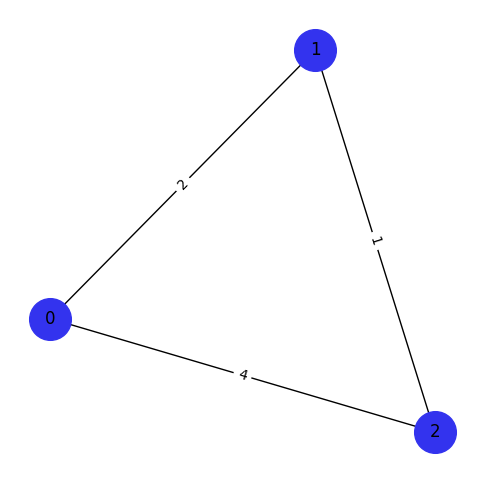

In [57]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = nx.Graph()

for i in range(len(dst_matrix)):
    for j in range(i + 1, len(dst_matrix)):
        if dst_matrix[i][j] != 0:
            G.add_edge(i, j, weight=dst_matrix[i][j])

plt.figure(figsize=(6, 6))

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color="#3333ee", node_size=900)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis("off")
plt.show()

Calling `to_bqm`, we translate the `qlassf` function into a `bqm` model.

In [46]:
bqm = tsp_f.to_bqm()
print("Vars:", bqm.num_variables, "\nInteractions:", bqm.num_interactions)

Vars: 18 
Interactions: 81


And now we can run it in a simulated annealing using the `neal` library. As we expected, the minimum energy sample is `(0,1,2)`.

In [49]:
import neal
from qlasskit.bqm import decode_samples

sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=10)
decoded_samples = decode_samples(tsp_f, sampleset)
best_sample = min(decoded_samples, key=lambda x: x.energy)
print(best_sample.sample, ":", best_sample.energy)

{'order': (0, 1, 2)} : 2.0
